In [1]:
import torch
from torch import nn 
import numpy as np
import gym
import matplotlib.pyplot as plt
import json

In [2]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.device = torch.device('cuda')
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 64), 
            nn.LeakyReLU(), 
            nn.Linear(64, self.action_dim)
        )
        #self.network.to(self.device)
        
        self.tanh = nn.Tanh()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.loss = nn.L1Loss()
        
    def forward(self, _input):
        #_input = _input.to(self.device)
        return self.network(_input)
    
    def get_action(self, state, exploration=0):
        state = torch.FloatTensor(state)
        #logits = self.forward(state).to('cpu')
        pure_action = self.forward(state).detach().numpy()
        #pure_action += exploration*np.random.randn(self.action_dim)
        action = pure_action + exploration*np.random.randn(self.action_dim)
        return np.clip(action,-1,1)
    
    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(np.array(elite_states))
        #elite_states = elite_states.to(self.device)
        elite_actions = torch.FloatTensor(np.array(elite_actions))
        #elite_actions = elite_actions.to(self.device)
        for i in range(15):
            self.optimizer.zero_grad()
            loss = self.loss(self.forward(elite_states), elite_actions)
            loss.backward()
            self.optimizer.step()

In [3]:
def get_trajectory(env, agent, trajectory_len, exploration=0, visualize=False, custom_reward_func = None):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0, 'custom_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)
    for i in range(trajectory_len):
        with torch.no_grad():
            action = agent.get_action(state, exploration)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        if custom_reward_func:
            reward = custom_reward_func(state) + reward
            trajectory['custom_reward'] = np.max([trajectory['custom_reward'],reward])
        
        if done:
            break
            
        if visualize:
            env.render()
        
        if(i != trajectory_len-1):
            trajectory['states'].append(state)
    
    if visualize:
        print(i,trajectory['total_reward'])  
    return trajectory

In [4]:
def get_elite_trajectories(trajectories, q_param, solved_traj):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    new_solved = [trajectory for trajectory in trajectories if trajectory['total_reward'] >= 200]
    if(len(new_solved)):
        solved_traj.extend(new_solved)
        pass
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]



In [5]:
env = gym.make("LunarLander-v2", continuous = True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
learnin_hist = {'mean_reward': [], 'exploration': [], 'validation': []}

agent = CEM(state_dim, action_dim)

In [6]:
trajectory_len = 400
q_param = 0.8
exploration = 0.9
e_rate = 0.993
solved_traj = []

In [7]:
%%time
episode_n = 1000
trajectory_n = 20

for episode in range(0,episode_n):
    trajectories = [get_trajectory(env, agent, trajectory_len, exploration) for _ in range(trajectory_n)]
    exploration *= e_rate
    mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
    print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
    elite_trajectories = get_elite_trajectories(trajectories, q_param, solved_traj)
    print('solved =',len(solved_traj),' elite len =',len(elite_trajectories))
    learnin_hist['exploration'].append([episode,mean_total_reward])
    learnin_hist['mean_reward'].append([episode,mean_total_reward])
    if episode%10==0:
        trajectories = [get_trajectory(env, agent, trajectory_len, -1) for _ in range(trajectory_n*3)]
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
        if(mean_total_reward>2600):
            break
        learnin_hist['validation'].append([episode,mean_total_reward])
        print('validation =', mean_total_reward)
    if len(elite_trajectories) > 0:
        if(len(solved_traj)>0):
            elite_trajectories.append(solved_traj[np.random.randint(len(solved_traj))])
            agent.update_policy(elite_trajectories)
        else:
            agent.update_policy(elite_trajectories)

episode: 0, mean_total_reward = -254.05904306815538
solved = 0  elite len = 4
validation = -218.70082960886074
episode: 1, mean_total_reward = -154.82057897663486
solved = 0  elite len = 4
episode: 2, mean_total_reward = -52.192377090410005
solved = 0  elite len = 4
episode: 3, mean_total_reward = -84.91816616536065
solved = 0  elite len = 4
episode: 4, mean_total_reward = -115.465942181334
solved = 0  elite len = 4
episode: 5, mean_total_reward = -75.53168735834083
solved = 0  elite len = 4
episode: 6, mean_total_reward = -61.03157032862712
solved = 0  elite len = 4
episode: 7, mean_total_reward = -122.36190474189125
solved = 0  elite len = 4
episode: 8, mean_total_reward = -151.54656903520586
solved = 0  elite len = 4
episode: 9, mean_total_reward = -92.71093656564292
solved = 0  elite len = 4
episode: 10, mean_total_reward = -105.84327457817434
solved = 0  elite len = 4
validation = -87.06131933780944
episode: 11, mean_total_reward = -74.56673946534397
solved = 0  elite len = 4
epis

KeyboardInterrupt: 

In [8]:
hist = np.array(learnin_hist['mean_reward'])
hist = hist[:400,:]

In [9]:
hist[:,0] *= trajectory_n

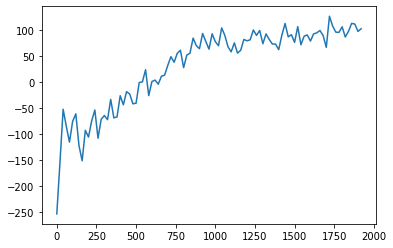

In [10]:
plt.plot(hist[:,0],hist[:,1])

In [11]:
np.savetxt('ce0.txt',hist)